    FRAME_X  FRAME_Y
0    -13.02   -19.77
1    -19.68    -7.46
2      2.61   -27.24
3    -19.80    -0.66
4     -9.61     0.42
5      8.96    -0.93
6      0.11     8.61
7      0.27    -5.61
8     -0.42    -9.35
9     19.76     7.11
10    -6.49    -6.17
11    -7.31    10.45
12    14.36    24.88
13    19.40    -9.02
14    -0.20     0.20
15    18.45   -27.28
16     1.79    30.07
17   -16.31    18.04
18   -48.51    -0.31
19     5.93     6.63
20    46.06    -0.39
21   -19.25     7.96
Pitch coordinates:
[[-52.5 -34. ]
 [-52.5  34. ]
 [ 52.5  34. ]
 [ 52.5 -34. ]
 [-52.5 -34. ]]
Single points:
[[-13.02 -19.77]
 [-19.68  -7.46]
 [  2.61 -27.24]
 [-19.8   -0.66]
 [ -9.61   0.42]
 [  8.96  -0.93]
 [  0.11   8.61]
 [  0.27  -5.61]
 [ -0.42  -9.35]
 [ 19.76   7.11]
 [ -6.49  -6.17]
 [ -7.31  10.45]
 [ 14.36  24.88]
 [ 19.4   -9.02]
 [ -0.2    0.2 ]
 [ 18.45 -27.28]
 [  1.79  30.07]
 [-16.31  18.04]
 [-48.51  -0.31]
 [  5.93   6.63]
 [ 46.06  -0.39]
 [-19.25   7.96]]


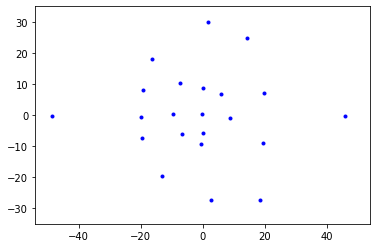

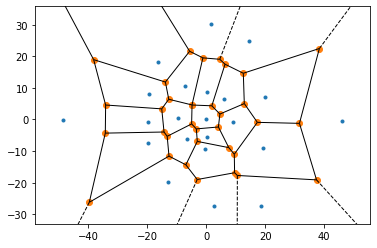

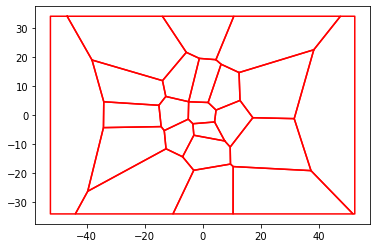

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from collections import defaultdict
from shapely.geometry import Polygon


# function to build voronoi polygons
def voronoi_polygons(voronoi, diameter):
    """Generate shapely.geometry.Polygon objects corresponding to the
    regions of a scipy.spatial.Voronoi object, in the order of the
    input points. The polygons for the infinite regions are large
    enough that all points within a distance 'diameter' of a Voronoi
    vertex are contained in one of the infinite polygons.
    """
    centroid = voronoi.points.mean(axis=0)

    # Mapping from (input point index, Voronoi point index) to list of
    # unit vectors in the directions of the infinite ridges starting
    # at the Voronoi point and neighbouring the input point.
    ridge_direction = defaultdict(list)
    for (p, q), rv in zip(voronoi.ridge_points, voronoi.ridge_vertices):
        u, v = sorted(rv)
        if u == -1:
            # Infinite ridge starting at ridge point with index v,
            # equidistant from input points with indexes p and q.
            t = voronoi.points[q] - voronoi.points[p]  # tangent
            n = np.array([-t[1], t[0]]) / np.linalg.norm(t)  # normal
            midpoint = voronoi.points[[p, q]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - centroid, n)) * n
            ridge_direction[p, v].append(direction)
            ridge_direction[q, v].append(direction)

    for i, r in enumerate(voronoi.point_region):
        region = voronoi.regions[r]
        if -1 not in region:
            # Finite region.
            yield Polygon(voronoi.vertices[region])
            continue
        # Infinite region.
        inf = region.index(-1)  # Index of vertex at infinity.
        j = region[(inf - 1) % len(region)]  # Index of previous vertex.
        k = region[(inf + 1) % len(region)]  # Index of next vertex.
        if j == k:
            # Region has one Voronoi vertex with two ridges.
            dir_j, dir_k = ridge_direction[i, j]
        else:
            # Region has two Voronoi vertices, each with one ridge.
            dir_j, = ridge_direction[i, j]
            dir_k, = ridge_direction[i, k]

        # Length of ridges needed for the extra edge to lie at least
        # 'diameter' away from all Voronoi vertices.
        length = 2 * diameter / np.linalg.norm(dir_j + dir_k)

        # Polygon consists of finite part plus an extra edge.
        finite_part = voronoi.vertices[region[inf + 1:] + region[:inf]]
        extra_edge = [voronoi.vertices[j] + dir_j * length,
                      voronoi.vertices[k] + dir_k * length]
        yield Polygon(np.concatenate((finite_part, extra_edge)))


# one example frame
df_points = pd.DataFrame(np.array([
    [-13.02, -19.77],
    [-19.68, -7.46],
    [2.61, -27.24],
    [-19.8, -0.66],
    [-9.61, 0.42],
    [8.96, -0.93],
    [0.11, 8.61],
    [0.27, -5.61],
    [-0.42, -9.35],
    [19.76, 7.11],
    [-6.49, -6.17],
    [-7.31, 10.45],
    [14.36, 24.88],
    [19.4, -9.02],
    [-0.2, 0.2],
    [18.45, -27.28],
    [1.79, 30.07],
    [-16.31, 18.04],
    [-48.51, -0.31],
    [5.93, 6.63],
    [46.06, -0.39],
    [-19.25, 7.96]
    ]), columns=['FRAME_X', 'FRAME_Y'])

v_pitch_size_x = 105
v_pitch_size_y = 68

print(df_points)

#create pitch coordinates based on the size
pitch = np.array([[(v_pitch_size_x / 2) * -1, (v_pitch_size_y / 2) * -1], [(v_pitch_size_x / 2) * -1, (v_pitch_size_y / 2)], [(v_pitch_size_x / 2), (v_pitch_size_y / 2)], [(v_pitch_size_x / 2), (v_pitch_size_y / 2) * -1], [(v_pitch_size_x / 2) * -1, (v_pitch_size_y / 2) * -1]])

print('Pitch coordinates:')
print(pitch)

# get X/Y and build nparray
points = df_points[['FRAME_X', 'FRAME_Y']].values
print('Single points:')
print(points)

# plot points & pitch
x, y = pitch.T
plt.xlim(round(x.min() - 1), round(x.max() + 1))
plt.ylim(round(y.min() - 1), round(y.max() + 1))
plt.plot(*points.T, 'b.')

#plot singe points
plt.show()


#calculate simple voronoi to plot
vor = Voronoi(points)
#plot voronoi
voronoi_plot_2d(vor)
plt.show()

# create boundary polygone based on pitch size
boundary_polygon = Polygon(pitch)

#create diameter to handle infinite voronoi regions
diameter = np.linalg.norm(pitch.ptp(axis=0))

i_point = 0
i_vor_point = 0

# calculate voronoi polygons & loop
for p in voronoi_polygons(Voronoi(points), diameter):
    # build intersection with pitch boundary polygon
    x, y = zip(*p.intersection(boundary_polygon).exterior.coords)

    v_frame_x = df_points.loc[i_point, 'FRAME_X']
    v_frame_y = df_points.loc[i_point, 'FRAME_Y']

    # loop points of polygon
    for i_order in range(0, len(x)):
        v_vor_x = x[i_order]
        v_vor_y = y[i_order]

        #print(v_frame_x, v_frame_y,
              #i_order, v_vor_x, v_vor_y)


    plt.plot(x, y, 'r-')

    # increase count for points
    i_point = i_point + 1


#plot result
plt.show()